# Exercise 5. Classification, shallow learning

The aim of this exercise is to train 4 different shallow learning models for predicting different classes from satellite data. It also assesses the model accuracy with a test dataset.

## Input data

2 raster files with:

* Coordinate system: Finnish ETRS-TM35FIN, EPSG:3067
* Resolution: 20m
* BBOX: 200000, 6700000, 300000, 6800000

#### Labels

* Multiclass classification raster: 1 - forest, 2 - fields, 3 - water, 4 - urban, 0 - everything else.

#### Data image

* Sentinel2 mosaic, with data from 2 different dates (May and July), to have more data values. Dataset has 8 bands based on bands: 2, 3, 4 and 8 on dates: 2021-05-11 and 2021-07-21, reflection values scaled to [0 ... 1]. The bands source data is: 
     *  'b02' / '2021-05-11'
     *  'b02' / '2021-07-21'
     *  'b03' / '2021-05-11'
     *  'b03' / '2021-07-21'
     *  'b04' / '2021-05-11'
     *  'b04' / '2021-07-21'
     *  'b08' / '2021-05-11'
     *  'b08' / '2021-07-21'

## Results

The trained models: 
* Random forest
* Stochastic Gradient Decent
* Gradient Boost
* SVM Suppot Vector Classifier

For each model:
* Trained model
* Model accuracy estimation
* Class confusion matrix
* Predicted image

## Main steps

1) Read data and shape it to suitable form for scikit-learn.
2) Resample to balance the dataset.
3) Divide the data to test and training datasets.
4) For each model:
   * Train the model.
   * Estimate the model on test data, inc class confusion matrix classification report creation.
   * Predict classification based on the data image and save it.
5) For SVM use grid search to find optimal settings.
6) Plot the results

## Imports and paths

In [2]:
import os, time
from imblearn.under_sampling import RandomUnderSampler
from joblib import dump, load
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import from_bounds
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
%matplotlib inline

In [3]:
os.getcwd()

'/scratch/project_2002044/geoml/02_shallows'

In [3]:
### File paths.
### Change the base_folder if needed
base_folder = ".."

image_url = 'https://a3s.fi/gis-courses/gis_ml/image.tif'
multiclass_classification_url = 'https://a3s.fi/gis-courses/gis_ml/labels_multiclass.tif'

outputBaseFolder= os.path.join(base_folder,'02_shallows')

# Input
image_file = os.path.join(base_folder, 'image.tif')
multiclass_classification_file = os.path.join(base_folder, 'labels_multiclass.tif')

no_bands_in_image = 8

# BBOX for exercise data, we use less than full image for shallow learning training, because of speed and to better see the results when plotting.
minx = 240500
miny = 6775500
maxx = 253500
maxy = 6788500 

# Available cores. During the course only 1 core is available, otherwise more cores could be available, so increase this then.
n_jobs = 1

(Download input data if needed.)

In [4]:
if not os.path.exists(image_file):
    urllib.request.urlretrieve(image_url, image_file)
    
if not os.path.exists(multiclass_classification_file):
    urllib.request.urlretrieve(multiclass_classification_url, multiclass_classification_file) 

## Read data and shape it to suitable form for scikit-learn

Read the input datasets with Rasterio and shape it to suitable form for scikit-learn.

Exactly the same as for K-means for image data, the similar processing only added for the labels image.

### Satellite image

The satellite image has 8 channels, so rasterio reads it in as 3D data cube.

For scikit-learn we reshape the data to 2D, having in dataframe one row for each pixel. Each pixel has eight values, one for each band/date.

In [5]:
# Read the pixel values from .tif file as dataframe
with rasterio.open(image_file) as image_dataset:
    image_data = image_dataset.read(window=from_bounds(minx, miny, maxx, maxy, image_dataset.transform))

# Check shape of input data
print ('Dataframe original shape, 3D: ', image_data.shape)    

Dataframe original shape, 3D:  (8, 650, 650)


As a mid-step transponse the axis order, so that the bands are the last. Notice how the dataframe size changes.

In [25]:
image_data2 = np.transpose(image_data, (1, 2, 0))
# Check again the data shape, now the bands should be last.
print ('Dataframe shape after transpose, 3D: ', image_data2.shape) 

Dataframe shape after transpose, 3D:  (650, 650, 8)


In [7]:
# Then reshape to 2D.
pixels = image_data2.reshape(-1, no_bands_in_image)
print ('Dataframe shape after transpose and reshape, 2D: ', pixels.shape) 

Dataframe shape after transpose and reshape, 2D:  (422500, 8)


### Forest classes image as labels

Do the same for labels.

In [8]:
# For labels only reshape to 1D is enough.
with rasterio.open(multiclass_classification_file) as labels_src:
    labels_data = labels_src.read(window=from_bounds(minx, miny, maxx, maxy, labels_src.transform))
    input_labels = labels_data.reshape(-1)
    print ('Labels shape after reshape, 1D: ', input_labels.shape)

Labels shape after reshape, 1D:  (422500,)


Notice that labels data has only one band.

In [9]:
labels_data.shape

(1, 650, 650)

### Resample to balance the dataset

The classes are very imbalanced in the dataset, so undersample the majority classes 

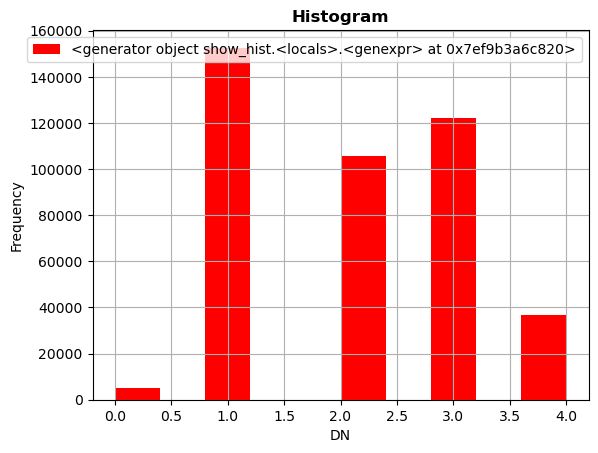

In [10]:
show_hist(labels_data)

In [11]:
rus = RandomUnderSampler(random_state=63)
pixels_resampled, labels_resampled = rus.fit_resample(pixels, input_labels)   
print ('Dataframe shape after undersampling of majority classes, 2D: ', pixels_resampled.shape)

Dataframe shape after undersampling of majority classes, 2D:  (24695, 8)


Notice that we lost a lot of pixel at this point, in real cases that much be undesired. See [inbalanced-learn User guide](https://imbalanced-learn.org/stable/user_guide.html#user-guide) for other options.

### Divide the data to test and training datasets

In [12]:
x_train, x_test, y_train, y_test = train_test_split(pixels_resampled, labels_resampled, test_size=0.2, random_state=63)

*How many pixels of different classes are included in training dataset?*

In [13]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=uint8), array([3938, 3974, 3954, 3949, 3941]))

## Funcitons for training and estimating the models and predicting based on the models

Similar functions will be used by different algorithms. Here the functions are only defined, they will be used later.

### Train the model

In [14]:
# Train the model and see how long it took.
def trainModel(x_train, y_train, clf, classifierName):
    start_time = time.time()    
    # training the model
    clf.fit(x_train, y_train)
    print('Model training took: ', round((time.time() - start_time), 2), ' seconds')
    
    # Save the model to a file
    modelFilePath = os.path.join(outputBaseFolder, ('model_' + classifierName + '.sav'))
    dump(clf, modelFilePath) 
    return clf

### Estimate the model on test data

In [15]:
# Predict on test data and see the model accuracy
def estimateModel(clf, x_test, y_test):
    test_predictions = clf.predict(x_test)
    print('Confusion matrix: \n', confusion_matrix(y_test, test_predictions))
    print('Classification report: \n', classification_report(y_test, test_predictions))

### Predict classification based on the data image and save it

In [16]:
# Predict on whole image and save it as .tif file
def predictImage(modelName, image_data):
    start_time = time.time()    
    
    #Set file paths
    classifiedImageFile = os.path.join(outputBaseFolder, ('classification_' + modelName + '.tif'))
    modelFile = os.path.join(outputBaseFolder, ('model_' + modelName + '.sav'))    
         
    #Load the model from the saved file
    trained_model = load(modelFile)

    # predict the class for each pixel
    prediction = trained_model.predict(pixels)

    # Reshape back to 2D
    print('Prediction shape in 1D: ', prediction.shape)
    prediction2D = np.reshape(prediction, (image_data.shape[1], image_data.shape[2]))
    print('Prediction shape in 2D: ', prediction2D.shape)

    # Save the results as .tif file.
    # Copy metadata from the labels image 
    outputMeta = labels_src.meta
    # Writing the image on the disk
    with rasterio.open(classifiedImageFile, 'w', **outputMeta) as dst:
        dst.write(prediction2D, 1)
    print('Predicting took: ', round((time.time() - start_time), 1), ' seconds')

## 5.3 Random forest     

In [17]:
classifierName = 'random_forest'
# Initialize the random forest classifier and give the hyperparameters.
clf_random_forest = RandomForestClassifier(n_estimators=200, max_depth=75, random_state=0, n_jobs=n_jobs)
clf_random_forest = trainModel(x_train, y_train, clf_random_forest, classifierName)
estimateModel(clf_random_forest, x_test, y_test)

#predictImage(classifierName, inputImage)
predictImage(classifierName)
print('Feature importances: \n', clf_random_forest.feature_importances_)

Model training took:  5.34  seconds
Confusion matrix: 
 [[582 113  78  18 210]
 [ 57 785  34   0  89]
 [ 61  52 785   0  87]
 [ 36   1   0 950   3]
 [ 88 173 136   5 596]]
Classification report: 
               precision    recall  f1-score   support

           0       0.71      0.58      0.64      1001
           1       0.70      0.81      0.75       965
           2       0.76      0.80      0.78       985
           3       0.98      0.96      0.97       990
           4       0.61      0.60      0.60       998

    accuracy                           0.75      4939
   macro avg       0.75      0.75      0.75      4939
weighted avg       0.75      0.75      0.75      4939

Prediction shape in 1D:  (422500,)
Prediction shape in 2D:  (650, 650)
Predicting took:  10.7  seconds
Feature importances: 
 [0.10636697 0.08069012 0.12553214 0.08219541 0.14360952 0.10114117
 0.17246326 0.18800141]


## 5.4 Stochastic Gradient Decent

In [18]:
classifierName = 'SGD'    
clf_SGD = SGDClassifier(loss="log_loss", learning_rate='adaptive', eta0=.1, alpha=1e-5,  n_jobs=n_jobs, max_iter=1000, penalty='l1') #
clf_SGD = trainModel(x_train, y_train, clf_SGD, classifierName)
estimateModel(clf_SGD, x_test, y_test)
predictImage(classifierName)

Model training took:  0.83  seconds
Confusion matrix: 
 [[284 244 193  98 182]
 [ 29 838  57   4  37]
 [ 40  85 736   1 123]
 [ 16   8   3 962   1]
 [ 58 289 184  53 414]]
Classification report: 
               precision    recall  f1-score   support

           0       0.67      0.28      0.40      1001
           1       0.57      0.87      0.69       965
           2       0.63      0.75      0.68       985
           3       0.86      0.97      0.91       990
           4       0.55      0.41      0.47       998

    accuracy                           0.65      4939
   macro avg       0.65      0.66      0.63      4939
weighted avg       0.65      0.65      0.63      4939

Prediction shape in 1D:  (422500,)
Prediction shape in 2D:  (650, 650)
Predicting took:  0.3  seconds


# 5.5 Gradient Boost    

In [19]:
classifierName = 'gradient_boost'    
clf_gradient_boost = GradientBoostingClassifier(n_estimators=200, learning_rate=.05)
clf_gradient_boost = trainModel(x_train, y_train, clf_gradient_boost, classifierName)
estimateModel(clf_gradient_boost, x_test, y_test)
predictImage(classifierName)
print('Feature importances: \n', clf_gradient_boost.feature_importances_)    

Model training took:  29.27  seconds
Confusion matrix: 
 [[540 130  75  16 240]
 [ 58 788  35   0  84]
 [ 75  49 752   0 109]
 [ 31   4   1 952   2]
 [ 70 179 129   4 616]]
Classification report: 
               precision    recall  f1-score   support

           0       0.70      0.54      0.61      1001
           1       0.69      0.82      0.75       965
           2       0.76      0.76      0.76       985
           3       0.98      0.96      0.97       990
           4       0.59      0.62      0.60       998

    accuracy                           0.74      4939
   macro avg       0.74      0.74      0.74      4939
weighted avg       0.74      0.74      0.74      4939

Prediction shape in 1D:  (422500,)
Prediction shape in 2D:  (650, 650)
Predicting took:  3.7  seconds
Feature importances: 
 [0.02175996 0.0514572  0.10127809 0.0150816  0.18921457 0.07005763
 0.16171598 0.38943496]


## 5.6 SVM Support Vector Classifier

SVM is slower than others, wait a moment.

In [20]:
classifierName = 'SVM'        
clf_svc = SVC(kernel='rbf', gamma='auto',  decision_function_shape='ovr')
clf_svc = trainModel(x_train, y_train, clf_svc, classifierName)
estimateModel(clf_svc, x_test, y_test)
# Predicting the image with SVM takes 2-3 min, so we skip it here. 
# We will next search for best settings and predict the image for best option.
# predictImage(classifierName, inputImage) #SVM   

Model training took:  22.33  seconds
Confusion matrix: 
 [[363 244 138  78 178]
 [ 15 854  58   4  34]
 [ 55  89 695   1 145]
 [ 24   6   1 958   1]
 [ 71 344 167  48 368]]
Classification report: 
               precision    recall  f1-score   support

           0       0.69      0.36      0.47      1001
           1       0.56      0.88      0.68       965
           2       0.66      0.71      0.68       985
           3       0.88      0.97      0.92       990
           4       0.51      0.37      0.43       998

    accuracy                           0.66      4939
   macro avg       0.66      0.66      0.64      4939
weighted avg       0.66      0.66      0.64      4939



## 5.7 Grid Search for SVC

Different models have different settings (hyperparameters) that can be used for searching best model. Grid search is one option to automatically search for better option. For more options in hyperparameter search see [CSC machine learning guide](https://docs.csc.fi/support/tutorials/hyperparameter_search/)

Here we try different `C` and `gamma` values for the SVM model. Grid search automatically saves the best model.

*Notice, how the results are improved from the first SVM result above.*

In [21]:
classifierName = 'SVC_grid_search'        
# Find the optimal parameters for SVM
param_grid = {'C': [1000, 10000], 'gamma': [1, 10]}
# Initialize the grid search, cv is the number of iterations, kept at minimum here for faster results.
grid = GridSearchCV(SVC(), param_grid, verbose=1, n_jobs=n_jobs, cv=2)    
# Try different options
grid = trainModel(x_train, y_train, grid, classifierName)

# Plot the best option
print('Best selected parameters: ',format(grid.best_params_))
print('Best estimator: ',format(grid.best_estimator_))

# Test the classifier using test data
estimateModel(grid, x_test, y_test)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Model training took:  226.23  seconds
Best selected parameters:  {'C': 1000, 'gamma': 10}
Best estimator:  SVC(C=1000, gamma=10)
Confusion matrix: 
 [[525 146  77  17 236]
 [ 38 811  35   1  80]
 [ 61  50 773   1 100]
 [ 40   2   0 945   3]
 [ 55 188 116   5 634]]
Classification report: 
               precision    recall  f1-score   support

           0       0.73      0.52      0.61      1001
           1       0.68      0.84      0.75       965
           2       0.77      0.78      0.78       985
           3       0.98      0.95      0.96       990
           4       0.60      0.64      0.62       998

    accuracy                           0.75      4939
   macro avg       0.75      0.75      0.74      4939
weighted avg       0.75      0.75      0.74      4939



In [22]:
# Predict again on the small tile.
predictImage(classifierName)  

Prediction shape in 1D:  (422500,)
Prediction shape in 2D:  (650, 650)
Predicting took:  358.7  seconds


## Plot the results

In [23]:
### Help function to normalize band values and enhance contrast. Just like what QGIS does automatically
def normalize(array):
    min_percent = 2   # Low percentile
    max_percent = 98  # High percentile
    lo, hi = np.percentile(array, (min_percent, max_percent))
    return (array - lo) / (hi - lo)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:title={'center':'labels'}>

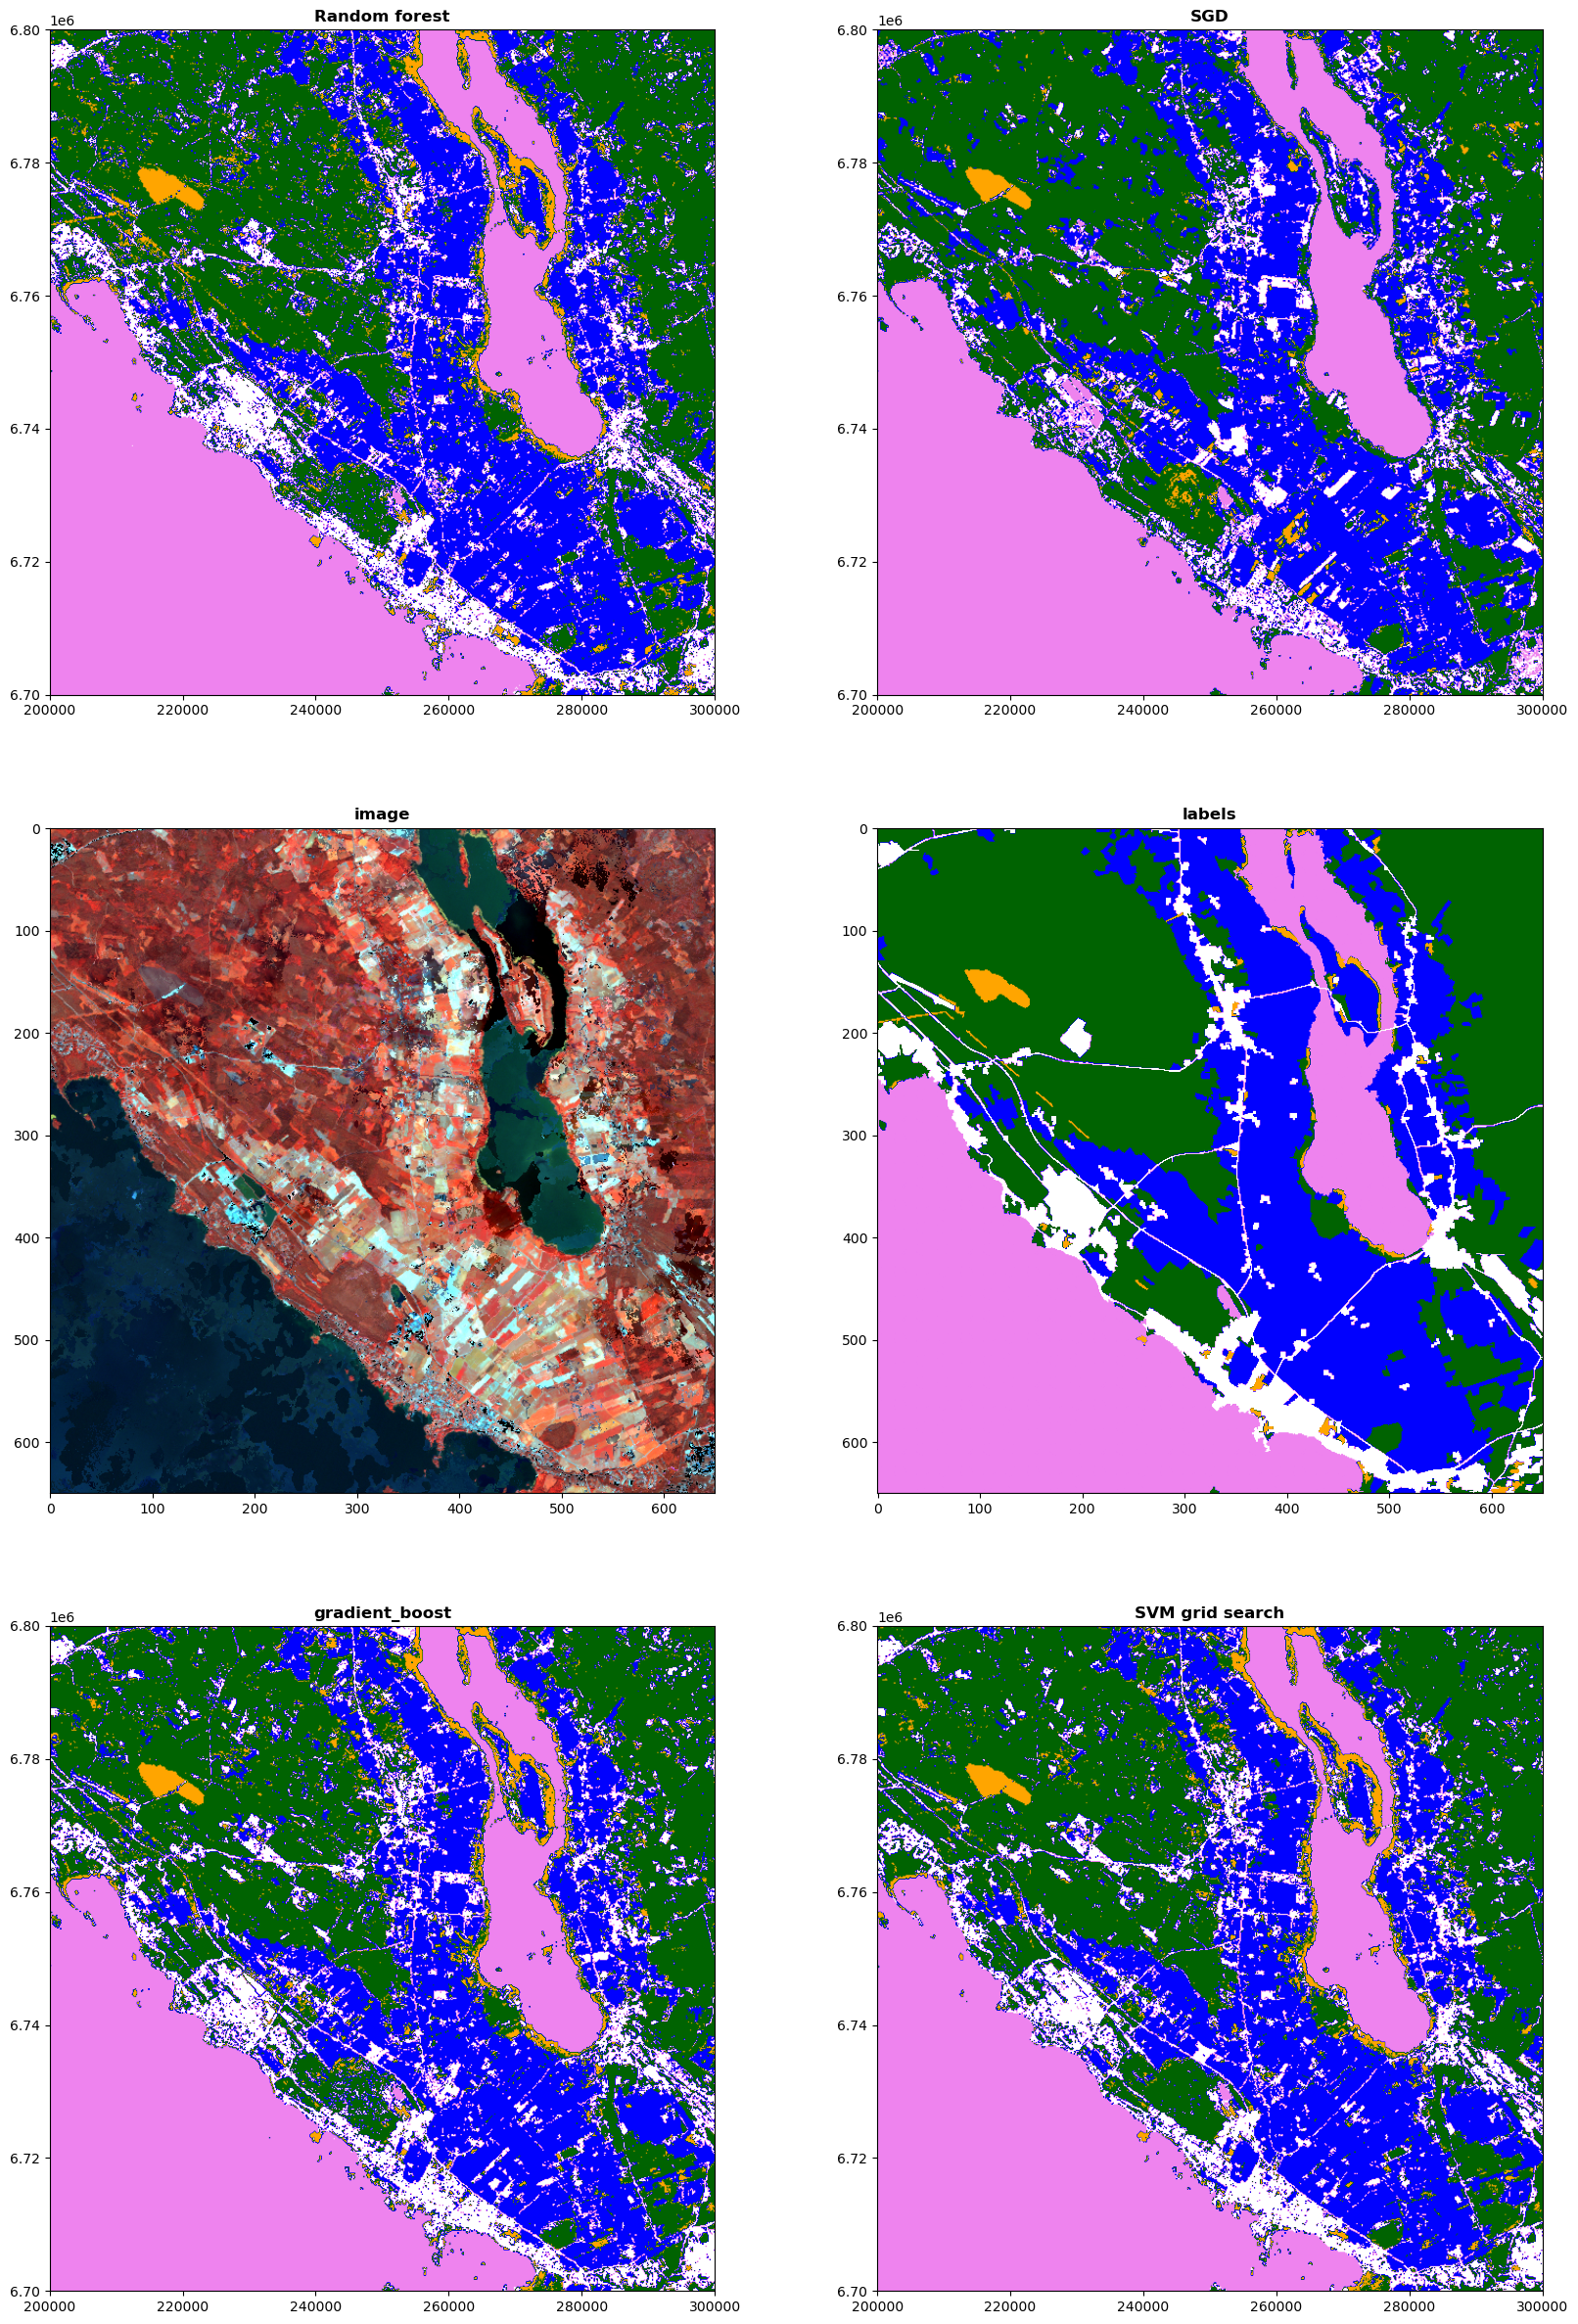

In [24]:
# Create a subplot for 6 images: 4 classification, 1 data image and 1 training labels. 
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(20, 30))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["orange","darkgreen","blue","violet","white"])

# The prediction results
rf_results = rasterio.open(os.path.join(outputBaseFolder,'classification_random_forest.tif'))
show(rf_results, ax=ax[0, 0], cmap=cmap, title='Random forest')

SGD_results = rasterio.open(os.path.join(outputBaseFolder,'classification_SGD.tif'))
show(SGD_results, ax=ax[0, 1], cmap=cmap, title='SGD')

gradient_boost_results = rasterio.open(os.path.join(outputBaseFolder,'classification_gradient_boost.tif'))
show(gradient_boost_results, ax=ax[2, 0], cmap=cmap, title='gradient_boost')

SVM_grid_search_results = rasterio.open(os.path.join(outputBaseFolder,'classification_SVC_grid_search.tif'))
show(SVM_grid_search_results, ax=ax[2, 1], cmap=cmap, title='SVM grid search')

# Plot the sentinel image 
nir, red, green = image_data[7,], image_data[3,], image_data[1,]
nirn, redn, greenn = normalize(nir), normalize(red), normalize(green)
stacked = np.stack((nirn, redn, greenn))
show(stacked, ax=ax[1,0], title='image') 

# Labels 
show(labels_data, ax=ax[1,1], cmap=cmap, title='labels')